In [1]:

import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
import networkx as nx

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch import optim
import torch.nn.functional as F
from torchvision.utils import make_grid

from tqdm import tqdm
from dataclasses import dataclass

from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Data transformations: conversion to tensors and normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# Download the MNIST dataset
test_dataset = datasets.MNIST(
    root='./data',  # Root directory for storing the dataset
    train=False,    # Use the test set
    transform=transform,  # Apply the specified transformations
    download=True   # Download the dataset if not already downloaded
)


# Create Siamese Neural Network:

In [3]:
@dataclass
class Configs:
    """
    Configuration class for model parameters and training settings.
    
    Attributes:
        input_shape (tuple): Shape of the input data.
        logs (dict): Dictionary to store training logs.
        input_dim (int): Dimension of the input features.
        output_dim (int): Dimension of the output features.
        num_block (int): Number of blocks or layers in the model.
        epochs (int): Number of training epochs.
        display_metrics (int): Frequency of displaying training metrics.
    """
    
    input_shape: tuple
    logs = {"Loss": []}  # Default log for Loss
    input_dim: int = 1    # Default input dimension
    output_dim: int = 64  # Default output dimension
    num_block: int = 2    # Default number of blocks or layers

    epochs: int = 25       # Default number of epochs
    display_metrics: int = 5  # Default frequency to display metrics


In [4]:
class SiameseNet(nn.Module):

    def __init__(self, configs):
        """
        Siamese Network class for feature extraction and comparison.
        
        Attributes:
            configs (Configs): Configuration object containing model parameters.
            num_block (int): Number of blocks or layers in the model.
            input_shape (tuple): Shape of the input data.
            module_dict (ModuleDict): Dictionary to store the network modules.
        """
        super(SiameseNet, self).__init__()

        # Initialize model parameters from configs
        input_dim = configs.input_dim
        output_dim = configs.output_dim
        self.num_block = configs.num_block
        self.input_shape = configs.input_shape

        # Initialize ModuleDict to store network modules
        self.module_dict = nn.ModuleDict()

        # Create convolutional blocks
        for i in range(configs.num_block):
            if i < configs.num_block-1:
                
                self.module_dict[f"Conv_Block_{i}"] = self.conv_block(
                    input_dim, output_dim
                )
            else: 
                self.module_dict[f"Conv_Block_{i}"] = self.conv_block(
                    input_dim, output_dim,
                    last_block = True
                )

            # Update input and output dimensions for the next block
            input_dim = output_dim
            output_dim = input_dim*2

        # Create fully connected block
        self.module_dict["fc_block"]= self.fc_block(input_dim)

    def conv_block(self, in_ch: int, out_ch: int, last_block: bool = False):
        """
        Create a convolutional block with optional max-pooling.
        
        Args:
            in_ch (int): Number of input channels.
            out_ch (int): Number of output channels.
            last_block (bool): Flag to indicate the last block.
        
        Returns:
            block (Sequential): Convolutional block.
        """
        
        if not last_block:
            block = nn.Sequential(
                nn.Conv2d(in_ch, out_ch,
                        kernel_size=3,
                        stride = 1,
                        padding = 1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.4),
                nn.BatchNorm2d(out_ch),
                nn.MaxPool2d(2,2)
            )
        else: 
            block = nn.Sequential(
                nn.Conv2d(in_ch, out_ch,
                        kernel_size=3,
                        stride = 1,
                        padding = 1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.4),
                nn.BatchNorm2d(out_ch),
            )
        return block
    
    def fc_block(self, in_ch: int):
        """
        Create a fully connected block with dropout.
        
        Args:
            in_ch (int): Number of input channels.
        
        Returns:
            block (Sequential): Fully connected block.
        """
        block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_ch*(((self.input_shape[1]//(2**(self.num_block-1)))**2)),
                                                1024),
            nn.ReLU(inplace = True),

            nn.Linear(1024,512),
            nn.ReLU(inplace = True),
            nn.Dropout(0.4),

            nn.Linear(512,128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.4),
            nn.Linear(128,2),
        )
        return block
    
    def forward_once(self, x):
        """
        Forward pass through the network for a single input.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            x (Tensor): Output tensor after passing through all modules.
        """
        
        for _, module in self.module_dict.items():

            x = module(x)

        return x
    
    def forward(self, x1, x2):
        
        """
        Forward pass through the network for two inputs.
        
        Args:
            x1 (Tensor): First input tensor.
            x2 (Tensor): Second input tensor.
        
        Returns:
            x1 (Tensor): Output tensor after passing through the network for x1.
            x2 (Tensor): Output tensor after passing through the network for x2.
        """

        if len(x1.shape) == 3:
            x1 = x1.unsqueeze(0)
        if len(x2.shape) == 3:
            x2 = x2.unsqueeze(0)

        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)

        return x1, x2

In [5]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive Loss class for Siamese networks.
    
    Attributes:
        margin (float): Margin value for the contrastive loss.
    """
    def __init__(self, margin=2.0):
        """
        Initialize ContrastiveLoss with a margin value.
        
        Args:
            margin (float): Margin value for the contrastive loss.
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """
        Compute the contrastive loss between two output tensors.
        
        Args:
            output1 (Tensor): Output tensor from the first input.
            output2 (Tensor): Output tensor from the second input.
            label (Tensor): Label indicating if the pair is similar (0) or dissimilar (1).
        
        Returns:
            loss_contrastive (Tensor): Computed contrastive loss.
        """
        
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        
        return loss_contrastive

In [6]:
# Initialize ContrastiveLoss
criterion = ContrastiveLoss()

# Define Siamese network configurations
siameseconfig = Configs(
    input_shape=(1, 28, 28),  # Shape of the input data
    input_dim=1,              # Dimension of the input features
    output_dim=128,           # Dimension of the output features
    num_block=2               # Number of blocks or layers in the model
)

# Create SiameseNet model based on the configurations and move it to the device (CPU/GPU)
model = SiameseNet(siameseconfig).to(device)

# Initialize Adam optimizer with a learning rate of 0.0005 and model parameters
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [7]:
# Créer un nouveau Dataset pour les paires d'images
class PairedMNISTDataset(Dataset):
    """
    Custom dataset class for generating pairs of images from the MNIST dataset.
    
    Attributes:
        test (Dataset): MNIST test dataset.
        mnist_dataset (Dataset): MNIST dataset used for generating pairs.
    """
    def __init__(self, mnist_dataset):
        """
        Initialize the PairedMNISTDataset with the given MNIST dataset.
        
        Args:
            mnist_dataset (Dataset): MNIST dataset.
        """

        self.test = mnist_dataset
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        """
        Generate a pair of images and a label indicating whether they are from the same class.
        
        Args:
            index (int): Index of the sample in the dataset.
        
        Returns:
            img0 (Tensor): First image tensor.
            img1 (Tensor): Second image tensor.
            label (Tensor): Label tensor indicating if the images are from the same class (0) or not (1).
        """

        img0, label0 = self.mnist_dataset[index]

        get_same_class = np.random.randint(0,2)

        if get_same_class:
            while True:

                index1 = np.random.randint(0, len(self.mnist_dataset) - 1)
                img1, label1 = self.mnist_dataset[index1]

                if label1==label0:

                    label = 0

                    break
        
        else: 
            while True:

                index1 = np.random.randint(0, len(self.mnist_dataset) - 1)
                img1, label1 = self.mnist_dataset[index1]

                if label1 != label0:
                    
                    label = 1

                    break

        return img0, img1, torch.from_numpy(np.array(label, dtype = np.float32))
    
    
    def __len__(self):
        """
        Return the number of samples in the dataset.
        
        Returns:
            length (int): Number of samples in the dataset.
        """
        return len(self.mnist_dataset)

test_data = PairedMNISTDataset(test_dataset)

In [8]:

def plot_image_pair(image1, image2, title):
    """
    Plot a pair of images side by side with a title.
    
    Args:
        image1 (Tensor): First image tensor.
        image2 (Tensor): Second image tensor.
        title (str): Title for the plot.
    """
    # Stack the images horizontally
    images = torch.stack([image1, image2])

    # Create a grid image from the stacked images
    grid_image = make_grid(images, nrow=2).cpu().numpy().transpose((1, 2, 0))

    # Plot the grid image
    plt.imshow(grid_image.squeeze())
    plt.title(title)
    plt.axis('off')
    plt.show()

In [9]:
def fit(dataloader, model, configs, optim, criterion):

    """
    Train the Siamese network model using the given data and configurations.
    
    Args:
        dataloader (DataLoader): DataLoader containing the training data.
        model (SiameseNet): Siamese network model to train.
        configs (Configs): Configuration object containing model and training settings.
        optim (Optimizer): Optimizer used for updating the model parameters.
        criterion (ContrastiveLoss): Contrastive loss criterion used for computing the loss.
    """

    configs.logs["loss_history"] = []
    counter = []
    for epoch in range(configs.epochs):

        pbar = tqdm(total = len(dataloader))
        pbar.set_description(f"Epoch: {epoch}/{configs.epochs}")
        
        for  data in dataloader:

            model.train()

            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)

            optim.zero_grad()
            
            output_1, output_2 = model(img0, img1)
            
            loss = criterion(output_1, output_2, label)


            configs.logs["Loss"].append(loss.item())
            loss.backward()
            optim.step()

            pbar.update(1)
            pbar.set_postfix({"Loss": configs.logs["Loss"][-1]})

        configs.logs["loss_history"].append(configs.logs["Loss"][-1])
        counter.append(epoch)

        if loss<0.0001:

            break
        
        if (epoch % configs.display_metrics == 0 )or (epoch == configs.epochs-1) :

            model.eval()
            with torch.no_grad():

                img_test0 = img0[-1]
                img_test1 = img1[-1]

                index_diff_label = torch.where(label[-1] != label)[0][0]
                
                img_test2 = img0[index_diff_label]
                img_test3 = img1[index_diff_label]

                eval1, eval2 = model(img_test0, img_test1)
                eval3, eval4 = model(img_test2, img_test3)

                euclidean_distance1 = F.pairwise_distance(eval1, eval2)
                euclidean_distance2 = F.pairwise_distance(eval3, eval4)

                plot_image_pair(img_test0, img_test1, f' score:{euclidean_distance1.item()}, label = {label[-1]}')
                plot_image_pair(img_test2, img_test3, f'score: {euclidean_distance2.item()}, label = {label[index_diff_label]}')

                plt.plot(counter, configs.logs["loss_history"])
                plt.show()

Epoch: 0/100: 100%|██████████| 313/313 [00:13<00:00, 24.73it/s, Loss=0.0144] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


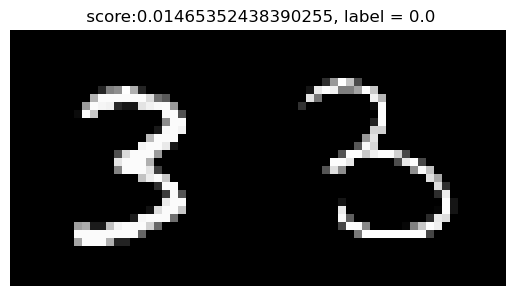

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


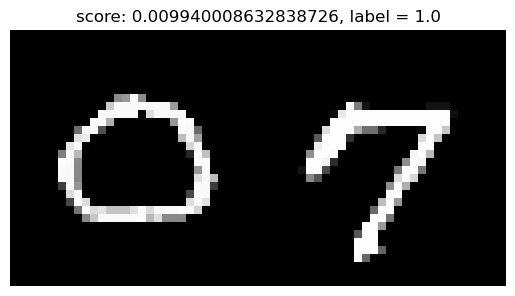

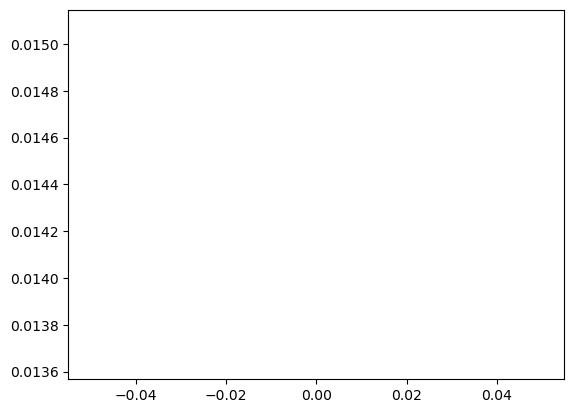

Epoch: 20/100: 100%|██████████| 313/313 [00:13<00:00, 24.59it/s, Loss=0.00356]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


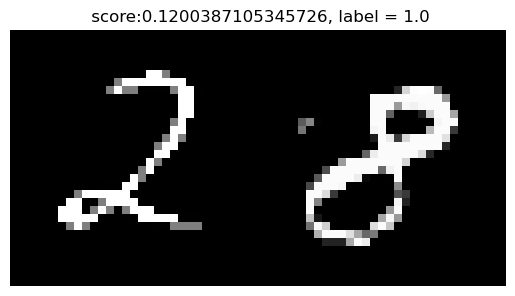

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


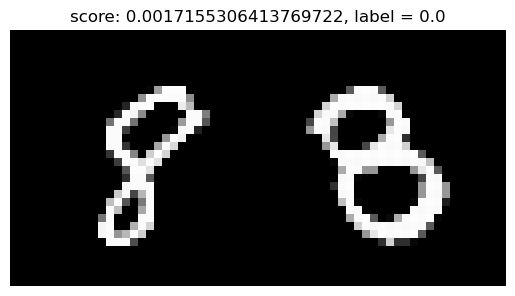

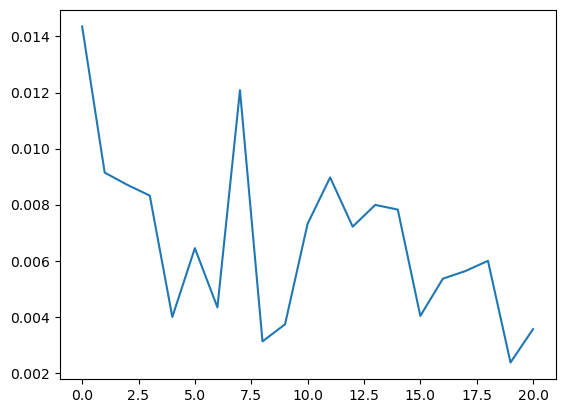

Epoch: 40/100: 100%|██████████| 313/313 [00:13<00:00, 23.03it/s, Loss=0.00234]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


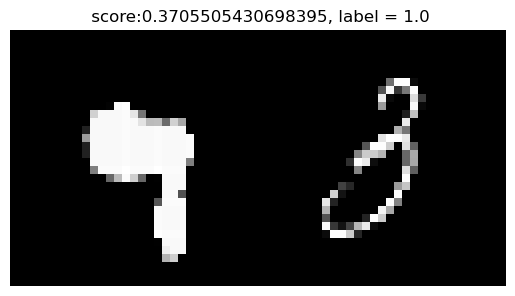

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


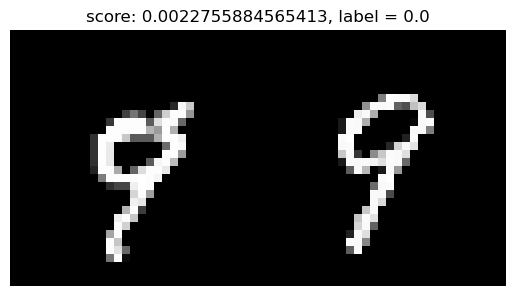

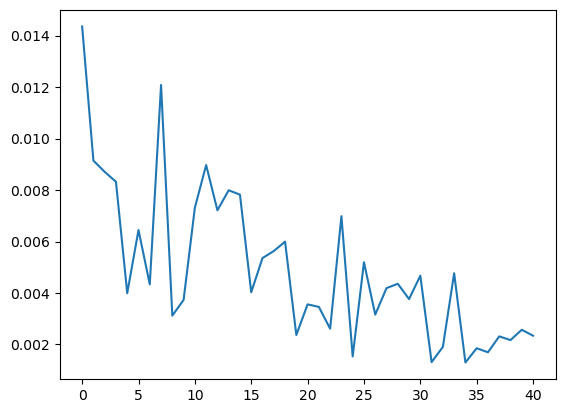

Epoch: 60/100: 100%|██████████| 313/313 [00:13<00:00, 24.89it/s, Loss=0.00181] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


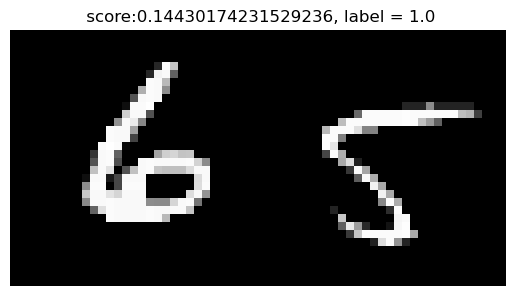

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


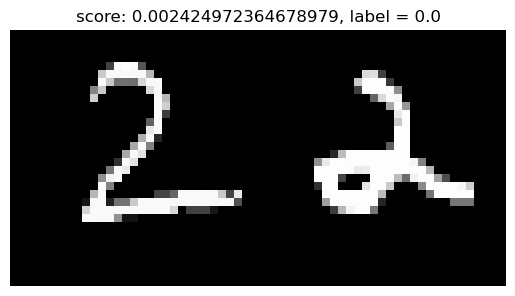

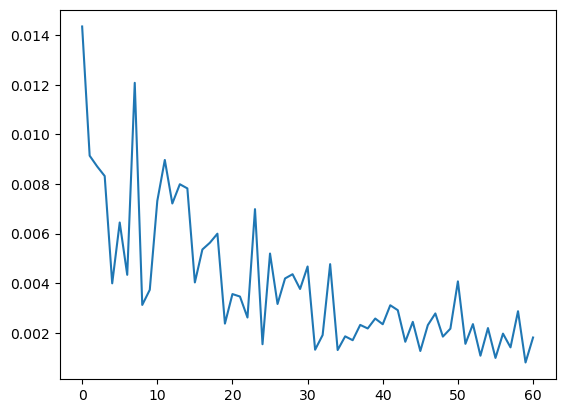

Epoch: 80/100: 100%|██████████| 313/313 [00:13<00:00, 24.87it/s, Loss=0.00329] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


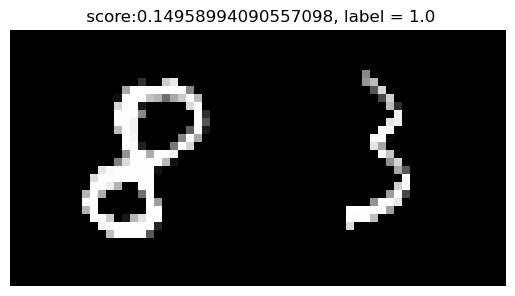

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


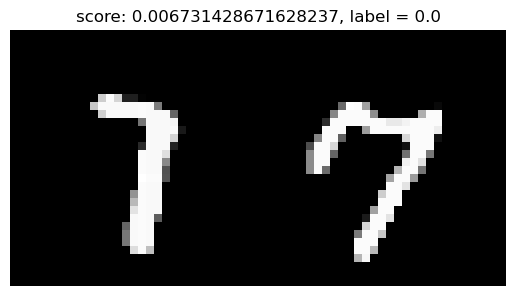

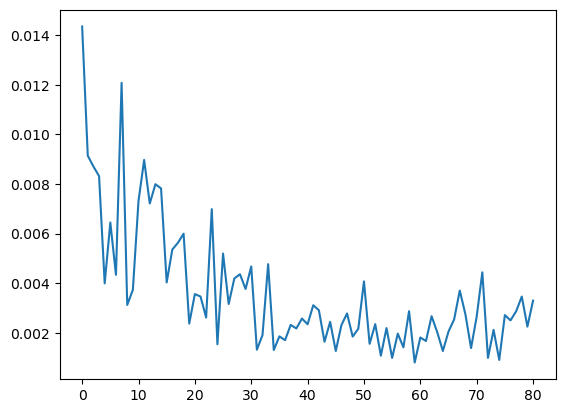

Epoch: 98/100: 100%|██████████| 313/313 [00:13<00:00, 23.82it/s, Loss=0.00159] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


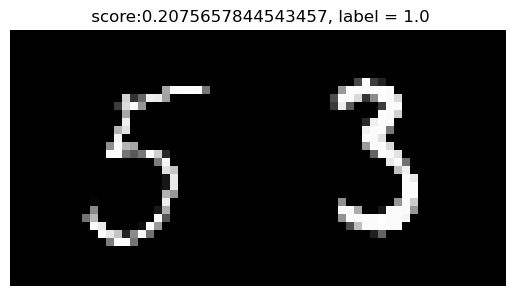

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


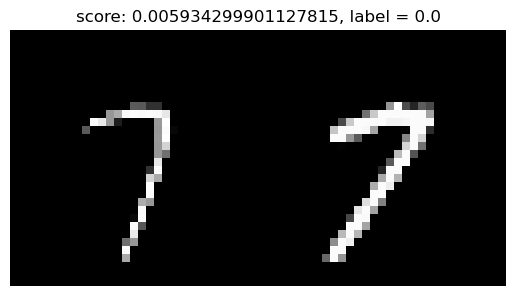

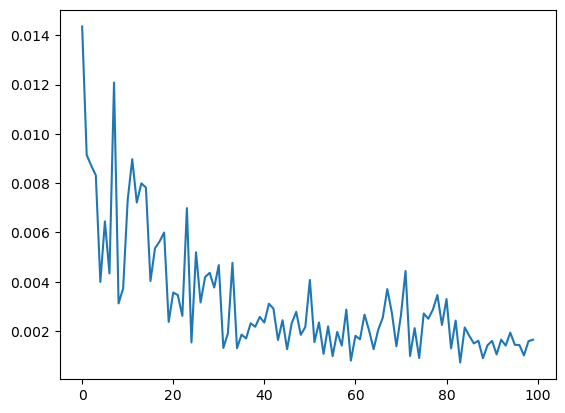

Epoch: 99/100: 100%|██████████| 313/313 [00:13<00:00, 22.73it/s, Loss=0.00165]


In [10]:
siameseconfig.epochs = 100
siameseconfig.display_metrics = 20

test_load = DataLoader(test_data, batch_size = 32, shuffle=True)
criterion = ContrastiveLoss(0.2)

fit(test_load, model, siameseconfig, optimizer, criterion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


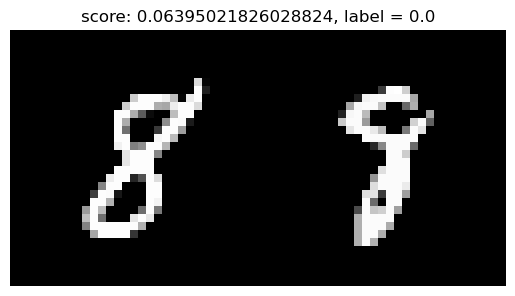

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


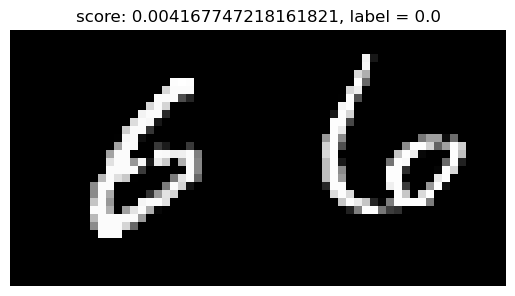

In [11]:
def evaluate_random_images(dataloader, model):
    """
    Evaluate the Siamese network model by plotting random pairs of images from the dataset.
    
    Args:
        dataloader (DataLoader): DataLoader containing the dataset to evaluate.
        model (SiameseNet): Siamese network model to evaluate.
    """
    
    # Set the model to evaluation mode
    model.eval()
    
    # Select random images from the dataset
    sample_indices = random.sample(range(len(dataloader.dataset)), 4)
    img0, img1, label0 = dataloader.dataset[sample_indices[0]]
    img2, img3, label2 = dataloader.dataset[sample_indices[2]]
    
    # Move the images to the device
    img0, img1, img2, img3 = img0.to(device), img1.to(device), img2.to(device), img3.to(device)
    
    # Forward pass through the model
    eval1, eval2 = model(img0.unsqueeze(0), img1.unsqueeze(0))
    eval3, eval4 = model(img2.unsqueeze(0), img3.unsqueeze(0))
    
    # Compute the Euclidean distances
    euclidean_distance1 = F.pairwise_distance(eval1, eval2).item()
    euclidean_distance2 = F.pairwise_distance(eval3, eval4).item()
    
    # Plot the image pairs and their scores
    plot_image_pair(img0, img1, f'score: {euclidean_distance1}, label = {label0}')
    plot_image_pair(img2, img3, f'score: {euclidean_distance2}, label = {label2}')

# Utilisez la fonction pour évaluer le modèle
evaluate_random_images(test_load, model)


In [12]:
torch.save(model.state_dict(), 'SiameseNet.pth')

## Create Graph from prediction link between images.

In [13]:
class PairedMNISTDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.test = mnist_dataset
        self.mnist_dataset = mnist_dataset
        self.unique_pairs_per_batch = self.get_unique_pairs()

    def get_unique_pairs(self):

        self.labels_per_batch = []
        self.images_per_batch = []
        unique_pairs_per_batch = []

        for data in self.mnist_dataset:
            images, labels = data

            self.images_per_batch.append(images)
            self.labels_per_batch.append(labels)

            unique_pairs = []

            for idx1, idx2 in itertools.combinations(range(len(images)), 2):
                unique_pairs.append((idx1, idx2))

            unique_pairs_per_batch.append(unique_pairs)

        return unique_pairs_per_batch
    
    def __getitem__(self, index):

        return self.images_per_batch[index]

    def __len__(self):
        
        return len(self.unique_pairs_per_batch)


In [14]:
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True)
data = PairedMNISTDataset(test_loader)
siameseconfig = Configs(
    input_shape=(1, 28, 28),  # Shape of the input data
    input_dim=1,              # Dimension of the input features
    output_dim=128,           # Dimension of the output features
    num_block=2               # Number of blocks or layers in the model
)
model = SiameseNet(siameseconfig)
model.load_state_dict(torch.load('SiameseNet.pth'))
model = model.to(device)

In [15]:
class MNISTGraph():
    def __init__(self, model, images, labels, pairs_indices):

        self.model = model
        self.pairs_indices= pairs_indices

        self.labels = labels
        self.images = images

        self.graphs = []
        self.links = [] 


    def normalise_data(self):
        normalized_data = (np.array(self.weight )- min(self.weight)) / (max(self.weight) - min(self.weight))*100
        new_data = []

        for value in normalized_data:
            new_data.append(int(value))
        
        self.weight = new_data
        

    def get_siamese_outputs(self, pairs_indices, images, labels):
        """
        Get siamese network outputs for the given pairs of image indices.
        
        Args:
        - pairs_indices (list of tuples): List of tuples containing pairs of image indices.
        
        Returns:
        - list: List of siamese network outputs for the given pairs of image indices.
        """
        self.weight = []
        G = nx.Graph()

        node_names = {i: f"{labels[i]}" for i in range(len(images))}
        nx.set_node_attributes(G, node_names, 'name')

        self.nodes = {i: {f"label": node_names[i], "image": images[i]} for i in range(len(images))}
         
        # Ajouter des nœuds avec des noms au graphe
        G.add_nodes_from(self.nodes.keys())
        #G.add_nodes_from(range(len(images)))

        for idx1, idx2 in pairs_indices:
            img1 = images[idx1].to(device)
            img2 = images[idx2].to(device)

            # Forward pass through the siamese network
            with torch.no_grad():

                output1, output2 = self.model(img1, img2)
                euclidean_distance = F.pairwise_distance(output1, output2).item()
                self.weight.append(euclidean_distance)

        self.normalise_data()
        i = 0
        for idx1, idx2 in pairs_indices:

            if self.weight[i] < 20:

                G.add_edge(idx1, idx2, weight = (1-euclidean_distance)*2)

            i+=1

        nx.set_node_attributes(G, self.nodes, 'attributes')
        nx.set_node_attributes(G, node_names, 'name')

        return G
    
    def __getitem__(self, index):
        label_batch = self.labels[index]
        unique_values, counts = torch.unique(label_batch, return_counts=True)

        for value, count in zip(unique_values, counts):
            print(f"Valeur : {value}, Occurrences : {count}")

        G = self.get_siamese_outputs(self.pairs_indices[index], self.images[index], self.labels[index])
        pos = nx.spring_layout(G, k= 1., iterations=70)

        nx.draw_networkx_nodes(G, pos)

        edges = G.edges()
        weights = [G[u][v]['weight'] for u,v in edges]
        nx.draw_networkx_edges(G, pos, width=weights)
        labels = nx.get_node_attributes(G, 'name')
        nx.draw_networkx_labels(G, pos, labels=labels)

        plt.show()
        return G

graphes = MNISTGraph(model, data.images_per_batch, data.labels_per_batch, data.unique_pairs_per_batch)

Valeur : 0, Occurrences : 3
Valeur : 1, Occurrences : 6
Valeur : 2, Occurrences : 3
Valeur : 3, Occurrences : 4
Valeur : 4, Occurrences : 2
Valeur : 5, Occurrences : 1
Valeur : 6, Occurrences : 2
Valeur : 7, Occurrences : 6
Valeur : 8, Occurrences : 3
Valeur : 9, Occurrences : 2


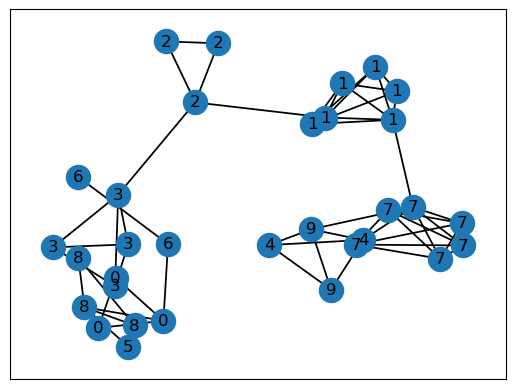

In [16]:
graphes[np.random.randint(0,300)]